In [1]:
import glob
from sklearn.model_selection import train_test_split
from skimage.measure import marching_cubes_lewiner, marching_cubes
import nibabel
import trimesh
import pandas as pd
import numpy as np
from natsort import natsorted
import plotly.graph_objects as go
import pymeshlab
sorted = natsorted
from numba import njit
import cc3d
import re
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
from datetime import datetime
import os
import shutil
import argparse
import time
import json
from collections import defaultdict
import pickle

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from models.v2v import V2VModel

import yaml
from easydict import EasyDict as edict

from utils import show_slices, check_patch, get_symmetric_value, pad_arrays

from multiprocessing import cpu_count
N_CPU = cpu_count()

In [82]:
class CatBrainMaskPathchLoader(Dataset):
    
    def __init__(self, config, train=True):
        self.root = config.root
        self.fcd_threshold = config.fcd_threshold
        self.train = train
         
        self.metadata = np.load(os.path.join(self.root, 'metadata.npy'), allow_pickle=True)
        self.metadata = self.metadata[self.metadata['is_train'] == train]

    def __getitem__(self, idx):
        
        metaindex = self.metadata.iloc[idx]
        
        tensor = torch.load(os.path.join(patches_data_root, f'tensor_{metaindex.label}'))
        x,y,z = metaindex[['x','y','z']].astype(int)

        x1,x2 = x-patch_size//2, x+patch_size//2
        y1,y2 = y-patch_size//2, y+patch_size//2
        z1,z2 = z-patch_size//2, z+patch_size//2

        brain_patch = tensor[0,x1:x2,y1:y2,z1:z2]
        label_patch = tensor[-1,x1:x2,y1:y2,z1:z2]
    
        return brain_patch, label_patch

    def __len__(self):
        return self.metadata.shape[0]

# Creating dataset

In [3]:
USE_GEOM_FEATURES = True
GEOM_FEATURES = ['thickness', 'sulc', 'curv']
patch_size=64
padding_size=patch_size//2

In [4]:
patches_data_root = f'../fcd_data/patches_dataset_{patch_size}' + ('_features' if USE_GEOM_FEATURES else '')

if not os.path.isdir(patches_data_root):
    os.makedirs(patches_data_root)

In [5]:
paths_dict = defaultdict(dict)
for p in os.listdir('../fcd_data/normalized_label'):
    
    label = p.split('.')[0]
    
    sub_root = f'../fcd_data/normalized_data/sub-{label}/anat/'
    brain_path = glob.glob(os.path.join(sub_root, '*Asym_desc-preproc_T1w.nii.gz'))[0]
    mask_path = glob.glob(os.path.join(sub_root, '*Asym_desc-brain_mask.nii.gz'))[0]
    label_path = f'../fcd_data/normalized_label/{p}' 
    
    # features
    if USE_GEOM_FEATURES:
        absent_feature = False
        for feature_name in GEOM_FEATURES:
            feature_path = f'../fcd_data/preprocessed_data_anadezhda/{feature_name}/norm-{label}.nii'
            if not os.path.isfile(feature_path):
                absent_feature=True
                continue
            paths_dict[label][f'{feature_name}'] = feature_path
        if absent_feature:
            continue
        
    paths_dict[label]['label'] = label_path
    paths_dict[label]['brain'] = brain_path    
    paths_dict[label]['mask'] = mask_path 

In [6]:
# for label, path_dict in tqdm(paths_dict.items()):
    
#     mask_tensor = nibabel.load(path_dict['mask']).get_fdata() > 0
#     brain_tensor = nibabel.load(path_dict['brain']).get_fdata() *mask_tensor.astype(int) 
#     label_tensor = nibabel.load(path_dict['label']).get_fdata() > 0
    
#     ################
#     # MAKE TENSORS #
#     ################
    
#     label_tensor, mask_tensor, brain_tensor = pad_arrays([label_tensor, 
#                                                           mask_tensor, 
#                                                           brain_tensor],
#                                                           padding_size)
    
    
#     brain_tensor_torch = torch.tensor(brain_tensor, dtype=torch.float)
#     label_tensor_torch = torch.tensor(label_tensor, dtype=torch.float)
    
#     if USE_GEOM_FEATURES:
        
#         feature_tensors = [nibabel.load(path_dict[f'{feature_name}']).get_fdata() \
#                            for feature_name in GEOM_FEATURES]
        
#         feature_tensors_torch = [torch.tensor(feature_tensor, dtype=torch.float) \
#                                 for feature_tensor in pad_arrays(feature_tensors, padding_size)]
    
#         torch_tensor = torch.stack([brain_tensor_torch] + feature_tensors_torch + [label_tensor_torch])
        
#     else:
#         torch_tensor = torch.stack([brain_tensor_torch, 
#                                     label_tensor_torch])
        
#     torch.save(torch_tensor, os.path.join(patches_data_root, f'tensor_{label}'))

#     X,Y,Z = mask_tensor.shape
#     X_mean = X//2

#     thresh_mask = (np.arange(X) < (X_mean - patch_size//2)) | (np.arange(X) > (X_mean + patch_size//2))
#     thresh_mask = np.tile(thresh_mask, (Y,Z,1)).transpose(2,0,1)
#     mask_tensor = mask_tensor*thresh_mask > 0

#     xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
#     xyz_grid = xyz_grid[mask_tensor]

#     indexes_selected = Parallel(n_jobs=N_CPU//2)(delayed(check_patch)(x,y,z,\
#                                                                 mask_tensor,\
#                                                                 label_tensor,\
#                                                                 patch_size) \
#                                            for x,y,z in xyz_grid)
    
#     indexes_selected = list(filter(lambda x: x is not None, indexes_selected))
    
#     np.save(os.path.join(patches_data_root, f'indexes_selected_{label}'), indexes_selected)

# Creating metadata

In [7]:
all_index_labels = []
all_indexes = []

for indexes_path in tqdm(glob.glob(os.path.join(patches_data_root, 'indexes_selected_*'))):
    
    label_index = os.path.basename(indexes_path).split('.')[0].split('_')[-1]
    indexes = np.load(indexes_path)
    
    all_indexes.append(indexes)
    all_index_labels.append(np.array([label_index]*len(indexes)))
        
all_index_labels = np.concatenate(all_index_labels) 
all_indexes = np.concatenate(all_indexes) # [x,y,z,p_mask,p_label]

100%|██████████| 81/81 [01:09<00:00,  1.16it/s]


In [39]:
FILLING_THRESHOLD = 0.5
f = all_indexes[:,-2]
mask_filling = f >= FILLING_THRESHOLD

all_index_labels = all_index_labels[mask_filling]
all_indexes = all_indexes[mask_filling]

In [40]:
np.random.seed(42)

FCD_THRESHOLD = 0.25

y = all_indexes[:,-1]
mask_fcd = y >= FCD_THRESHOLD
mask_nofcd = y == 0

N_fcd = mask_fcd.sum()

random_non_fcd_index = np.random.choice(np.arange(len(mask_nofcd))[mask_nofcd], size=N_fcd, replace=False)
mask_nofcd_trunk = np.zeros(len(mask_fcd),dtype=bool)
mask_nofcd_trunk[random_non_fcd_index] = True

mask_total = mask_fcd | mask_nofcd_trunk

In [41]:
mask_total.sum()

11068

In [42]:
# plt.hist(y, bins=50)
# plt.yscale('log')
# plt.show()

In [43]:
all_index_labels_ = all_index_labels[mask_total]
all_indexes_ = all_indexes[mask_total]
stratify_mask = y[mask_total] > 0

In [44]:
metadata = pd.DataFrame(all_indexes_, columns=['x','y','z','p_mask','p_label'])
metadata['label'] = all_index_labels_

In [45]:
stratify_mask.sum()

5534

# Make train-test split

In [46]:
np.random.seed(42)
metadata_train, metadata_test = train_test_split(metadata, stratify=stratify_mask.astype(int))

In [87]:
metadata_train.to_csv(os.path.join(patches_data_root,'metadata_train'), index=None)
metadata_test.to_csv(os.path.join(patches_data_root,'metadata_test'), index=None)

In [88]:
pd.read_csv('../fcd_data/patches_dataset_64_features/metadata_test')

,x,y,z,p_mask,p_label,label
0,204.0,231.0,107.0,0.608700,0.262600,38
1,192.0,221.0,104.0,0.521706,0.256668,38
2,203.0,218.0,107.0,0.629223,0.253483,38
3,202.0,221.0,107.0,0.624714,0.261356,38
4,206.0,229.0,109.0,0.638565,0.264187,38
...,...,...,...,...,...,...
2762,200.0,225.0,109.0,0.625278,0.265423,38
2763,81.0,192.0,210.0,0.606632,0.000000,48
2764,202.0,133.0,144.0,0.649200,0.000000,38
2765,199.0,218.0,105.0,0.586994,0.253483,38


# Visualization

In [53]:
N_train, N_test = metadata_train.shape[0], metadata_test.shape[0]

In [77]:
train_label_mask = metadata_train['p_label'] > 0
metadata_train_label = metadata_train[train_label_mask]

In [78]:
for index in np.random.choice(np.arange(metadata_train_label.shape[0]), size=9):
    metaindex = metadata_train_label.iloc[index]
    tensor = torch.load(os.path.join(patches_data_root, f'tensor_{metaindex.label}'))
    x,y,z = metaindex[['x','y','z']].astype(int)
    
    x1,x2 = x-patch_size//2, x+patch_size//2
    y1,y2 = y-patch_size//2, y+patch_size//2
    z1,z2 = z-patch_size//2, z+patch_size//2
    
    brain_patch = tensor[0,x1:x2,y1:y2,z1:z2].numpy()
    label_patch = tensor[-1,x1:x2,y1:y2,z1:z2].numpy()
    
    break

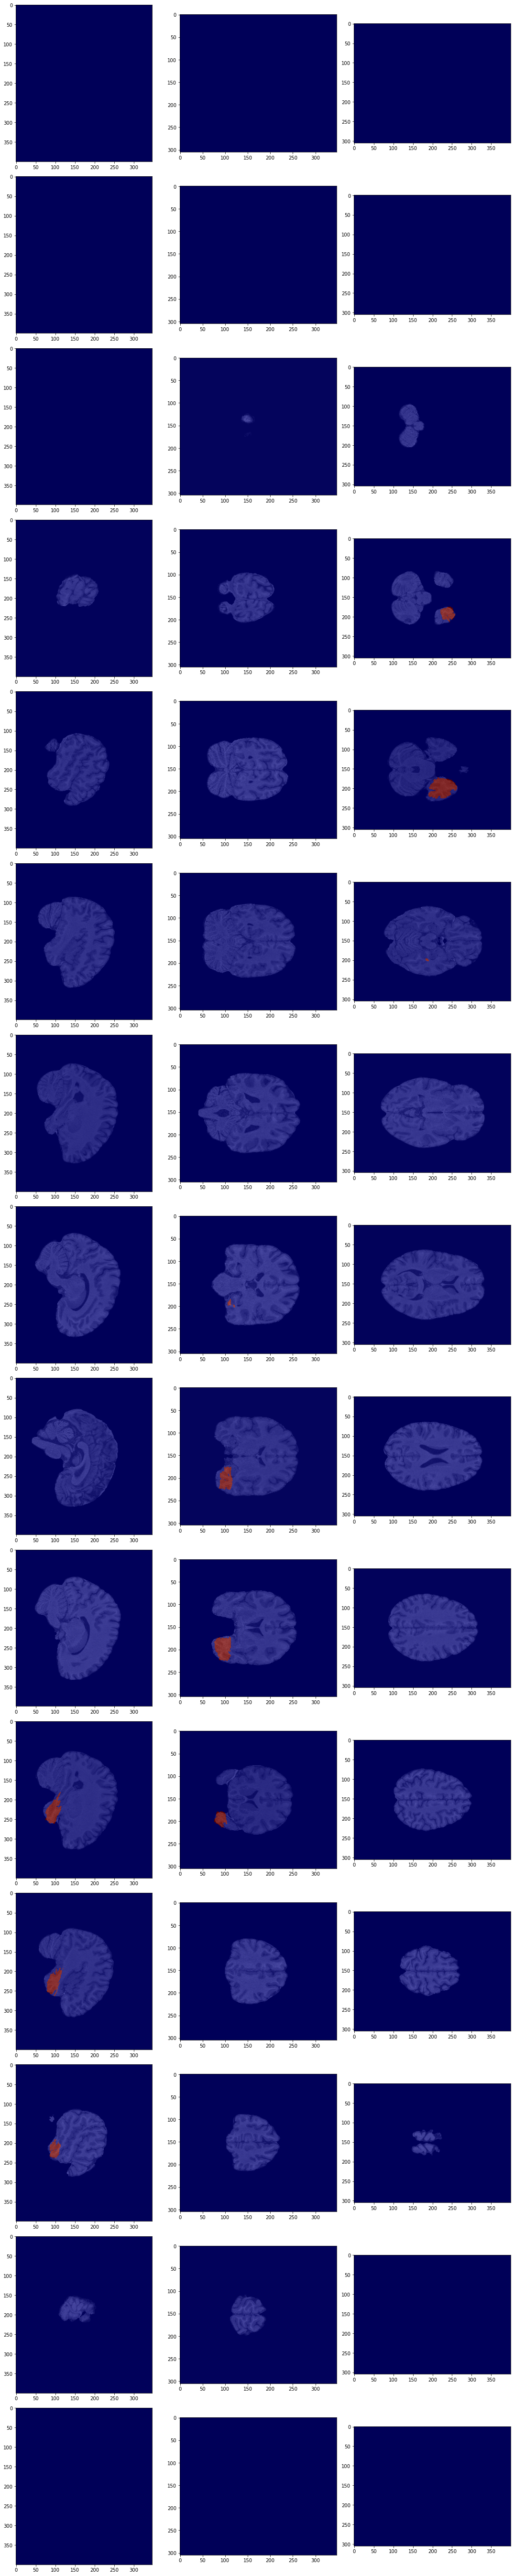

In [81]:
show_slices(tensor[0].numpy(), mask_tensor=tensor[-1].numpy(), n_slices_show=15)

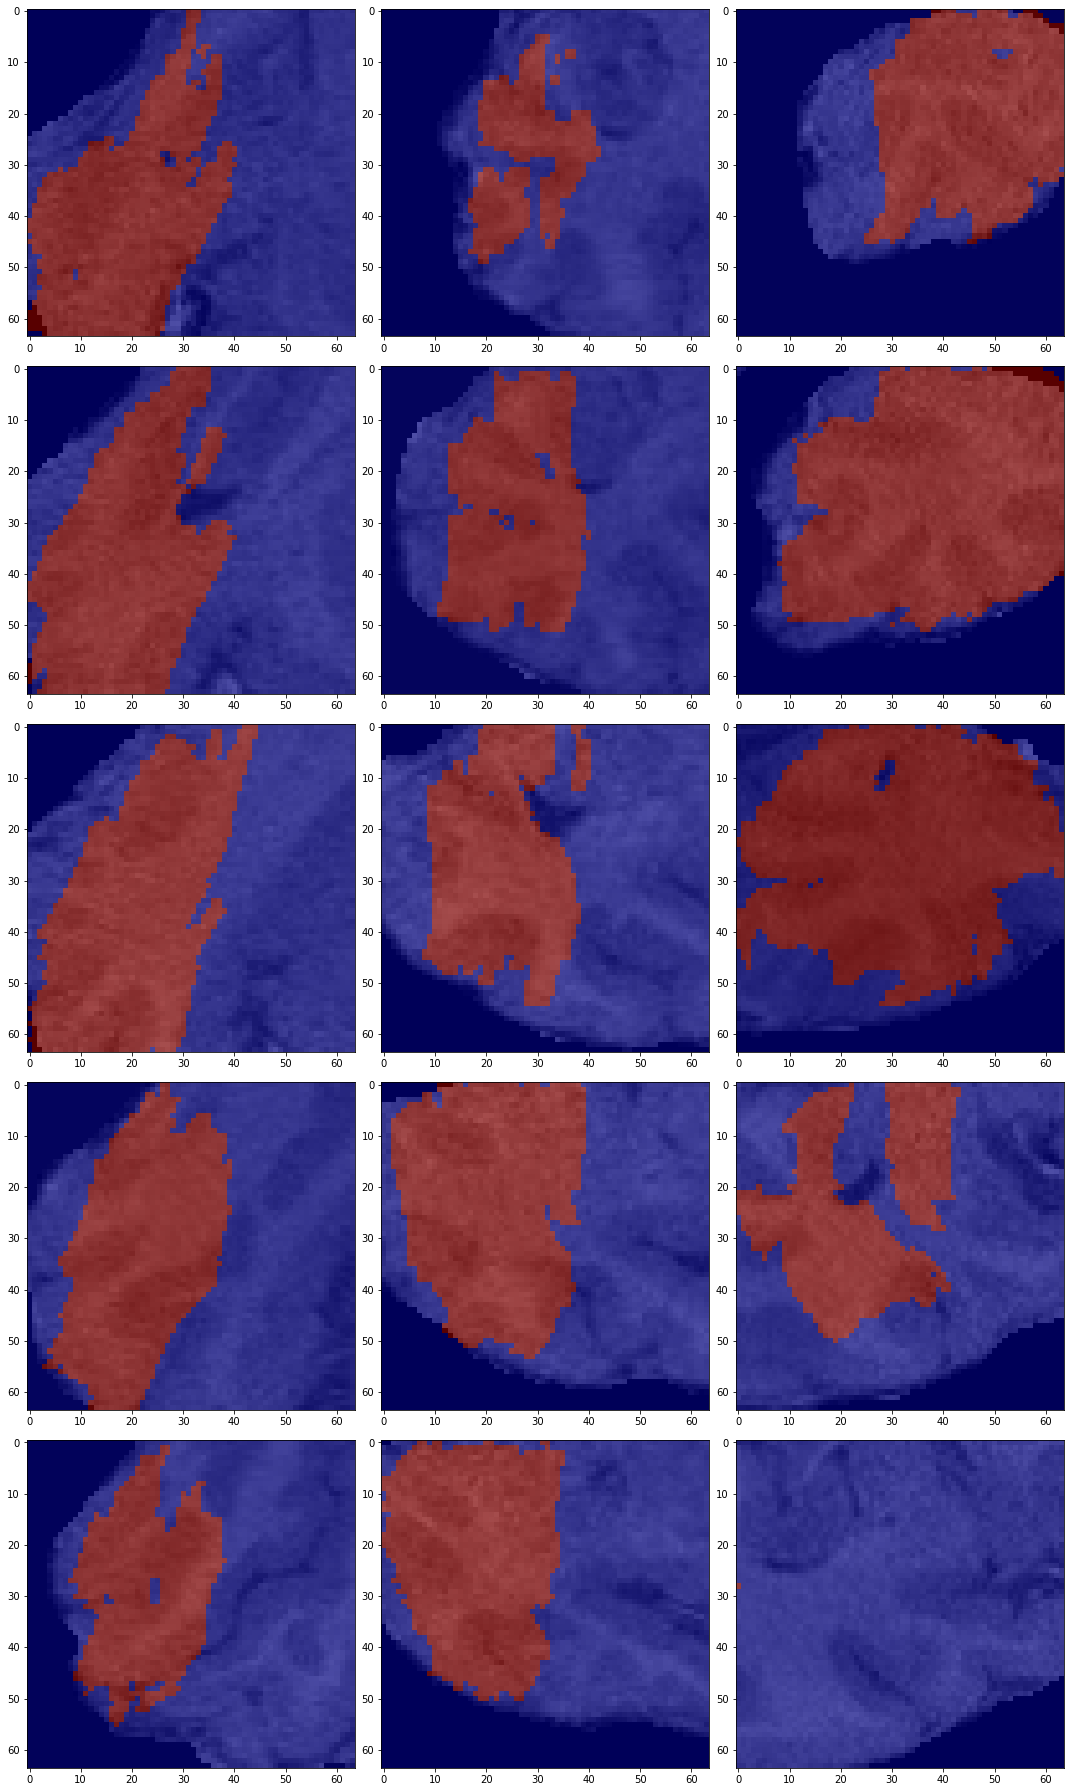

In [79]:
show_slices(brain_patch, mask_tensor=label_patch)